# **Proyecto Redes Neuronales**
Camila Johana González Acosta 599303

En este proyecto vamos a trabajar con una base de datos que alimentamos mis compañeros de salón y yo, de imagenes de numeros. El objetivo es encontrar el mejor modelo de redes neuronales convolucionales que pueda clasificar los numeros al presentarselos.

1. Verificamos con tensorflow que el GPU este conectado correctamente.

In [3]:
import tensorflow as tf

# Check if TensorFlow is using the GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


2. Importamos la base de datos que descargamos anteriormente a nuestra computadora.

In [4]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

zip_name = list(uploaded.keys())[0]

print(f"\nZIP recibido: {zip_name}")

extract_path = "/content/data"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(extract_path)

print("\nDescompresión completa en:", extract_path)

train_path = None
test_path = None
train_names = ["train", "Train", "TRAIN"]
test_names  = ["test", "Test", "TEST"]

for root, dirs, files in os.walk(extract_path):
    for d in dirs:
        if d in train_names:
            train_path = os.path.join(root, d)
        if d in test_names:
            test_path = os.path.join(root, d)

print("\n================ RESULTADOS ================")
print("Ruta Train detectada:", train_path)
print("Ruta Test detectada :", test_path)
print("============================================")

# Validar
if train_path is None or test_path is None:
    raise Exception("No se pudieron encontrar carpetas Train y Test. Verifica la estructura del ZIP.")
else:
    print("Rutas correctas detectadas y listas para usar.")


Saving Numbers.zip to Numbers.zip

ZIP recibido: Numbers.zip

Descompresión completa en: /content/data

================ RESULTADOS ================
Ruta Train detectada: /content/data/Numbers/Train
Ruta Test detectada : /content/data/Numbers/Test
✅ Rutas correctas detectadas y listas para usar.


3. Definimos la arquitectura base

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (28, 28)
batch_size = 32

# Usamos tus rutas detectadas:
train_path = "/content/data/Numbers/Train"
test_path  = "/content/data/Numbers/Test"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2   # 20% validación
)

train_gen = datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

from tensorflow.keras import layers, models

def build_cnn(conv_filters=[32,64], dense_units=128, dropout=0.25, bn=False):
    model = models.Sequential()
    model.add(layers.Input(shape=(28,28,1)))

    for f in conv_filters:
        model.add(layers.Conv2D(f, (3,3), padding='same'))
        if bn:
            model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.MaxPooling2D((2,2)))
        model.add(layers.Dropout(dropout/2))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(10, activation='softmax'))

    return model

Found 5685 images belonging to 10 classes.
Found 1415 images belonging to 10 classes.
Found 1866 images belonging to 10 classes.


4. Se entrenan 5 modelos usando la arquitectura base pero cambiando las configuraciones de cada uno para poder identificar el que tenga un mejor rendimiento.

In [8]:
configs = [
    {"conv_filters":[32,64], "dense_units":128, "dropout":0.25, "bn":False},
    {"conv_filters":[32,64], "dense_units":256, "dropout":0.3,  "bn":True},
    {"conv_filters":[64,128], "dense_units":128, "dropout":0.3, "bn":True},
    {"conv_filters":[32,32,64], "dense_units":128, "dropout":0.2, "bn":True},
    {"conv_filters":[16,32,64], "dense_units":64, "dropout":0.25, "bn":False},
]

from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

histories = []
val_accuracies = []
models_list = []

for cfg in configs:
    print("\nEntrenando modelo:", cfg)

    model = build_cnn(**cfg)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    es = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[es],
        verbose=1
    )

    histories.append(history)
    models_list.append(model)
    val_accuracies.append(max(history.history["val_accuracy"]))



Entrenando modelo: {'conv_filters': [32, 64], 'dense_units': 128, 'dropout': 0.25, 'bn': False}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 217ms/step - accuracy: 0.1860 - loss: 2.1971 - val_accuracy: 0.5413 - val_loss: 1.5182
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 34s 191ms/step - accuracy: 0.5799 - loss: 1.2910 - val_accuracy: 0.6898 - val_loss: 1.0994
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - accuracy: 0.6957 - loss: 0.9304 - val_accuracy: 0.7534 - val_loss: 0.9579
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 34s 189ms/step - accuracy: 0.7532 - loss: 0.7575 - val_accuracy: 0.7689 - val_loss: 0.8685
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - accuracy: 0.7826 - loss: 0.6837 - val_accuracy: 0.7802 - val_loss: 0.7867
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 34s 191ms/step - accuracy: 0.7962 - loss: 0.6241 - val_accuracy: 0.7809 - val_loss: 0.7767
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - accuracy: 0.8261 - loss: 0.5453 - val_accuracy: 0.7816 - val_loss: 0.8347
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - accuracy: 0.8383 - loss: 0

5. Se selecciona el mejor modelo.

In [9]:
best_index = np.argmax(val_accuracies)
best_model = models_list[best_index]
best_config = configs[best_index]
best_acc = val_accuracies[best_index]

print("\n====================================")
print("Mejor modelo encontrado")
print("Configuración:", best_config)
print("Accuracy de validación:", best_acc)
print("====================================")



Mejor modelo encontrado
Configuración: {'conv_filters': [32, 32, 64], 'dense_units': 128, 'dropout': 0.2, 'bn': True}
Accuracy de validación: 0.8381625413894653


6. Se entrena el modelo ganador con todos los datos de Train.

In [10]:
full_datagen = ImageDataGenerator(rescale=1./255)

full_train_gen = full_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

best_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history_final = best_model.fit(full_train_gen, epochs=10)


Found 7100 images belonging to 10 classes.
Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 46s 174ms/step - accuracy: 0.8788 - loss: 0.3891
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.8865 - loss: 0.3472
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 153ms/step - accuracy: 0.8880 - loss: 0.3264
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - accuracy: 0.8985 - loss: 0.3002
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - accuracy: 0.8997 - loss: 0.2856
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 156ms/step - accuracy: 0.9028 - loss: 0.2759
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - accuracy: 0.9155 - loss: 0.2515
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.9162 - loss: 0.2461
Epoch 9/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.9317 - loss: 0.2097
Epoch 10/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - accuracy: 0.9270 - loss: 0.2158


7. Se obtiene el accuracy en Test del modelo ganador.

In [11]:
test_loss, test_acc = best_model.evaluate(test_gen)
print("\nAccuracy final en test:", test_acc)

59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.8839 - loss: 0.4428

Accuracy final en test: 0.8788853287696838


8. Generamos una matriz de confusión para observar detalladamente el accuracy de nuestro modelo ganador.

59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step
              precision    recall  f1-score   support

           0       0.05      0.50      0.08         2
           1       0.82      0.94      0.88       211
           2       0.97      0.81      0.88       209
           3       0.91      0.86      0.89       207
           4       0.86      0.87      0.87       207
           5       0.88      0.90      0.89       204
           6       0.94      0.90      0.92       208
           7       0.87      0.87      0.87       207
           8       0.93      0.88      0.91       207
           9       0.84      0.87      0.86       204

    accuracy                           0.88      1866
   macro avg       0.81      0.84      0.80      1866
weighted avg       0.89      0.88      0.88      1866



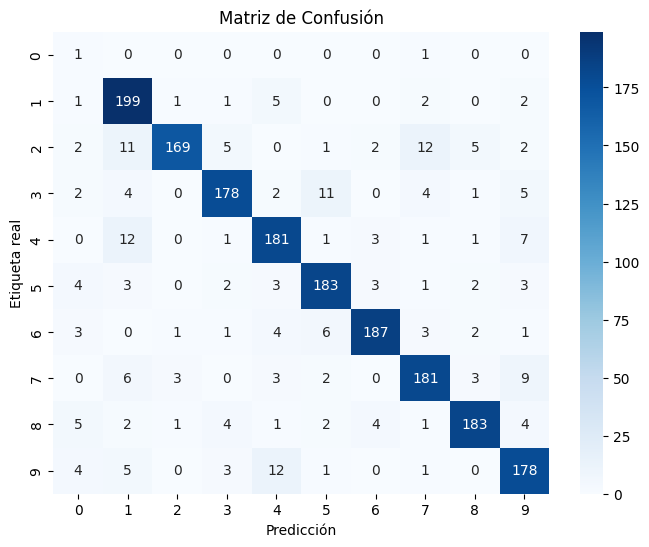

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

pred_prob = best_model.predict(test_gen)
y_pred = np.argmax(pred_prob, axis=1)
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()

**Conclusiones del modelo ganador:**

La matriz de confusión y el reporte de métricas muestran que el modelo tiene un buen desempeño general (88% de exactitud), con una alta capacidad para reconocer la mayoría de los dígitos, especialmente el 2, 3, 5, 6, 7 y 8, que presentan valores equilibrados y altos de precisión y recall. Esto indica que el modelo suele predecir correctamente estas clases y rara vez las confunde con otras.

El principal punto débil es el dígito 0, que aparece con muy bajo rendimiento debido a que está muy poco representado en el conjunto de prueba, lo cual impide que el modelo aprenda patrones robustos para identificarlo correctamente.

También se observan confusiones moderadas entre dígitos con formas parecidas, como 3–8 o 4–9. En general, el modelo demuestra ser sólido y consistente, y sus errores se explican principalmente por el desbalance en los datos y la similitud visual entre ciertos dígitos.


9. Descargamos el modelo ganador.

In [12]:
best_model.save("best_model_numbers.h5")
from google.colab import files
files.download("best_model_numbers.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>